In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import os 
import copy

from pathlib import Path

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Only GPU 3 is visible to this code

device = torch.device("cuda")

In [3]:
def single2tensor4(img):
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

def normalize(img, min_val = 0, max_val = 1):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) * (max_val - min_val) + min_val

# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path, load_dims=False, read_mode="color", fig_size = 224):

    mode = "RGB" if read_mode == "color" else "L"
    # laod image
    img = normalize(np.load(image_path), 0, 255)[0 : fig_size, 0 : fig_size]
    
    # gray to rgb for vgg
    if mode == "L":
        # Expand the 1 channel grayscale to 3 channel grayscale image
        temp = np.zeros(img.shape + (3,), dtype=np.uint8)
        temp[:, :, 0] = img
        temp[:, :, 1] = img.copy()
        temp[:, :, 2] = img.copy()
        img = temp 

    return Image.fromarray(img)

loader = transforms.Compose([
    transforms.Resize((512,512)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

In [4]:

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
def get_result(tensor):
    global unloader
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return np.asarray(image.convert('L')).astype(np.float64)
    
def save_result(tensor, save_path):
    np.save(save_path, get_result(tensor))

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [7]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
# style_layers_default = ['conv_{}'.format(i) for i in range(1,17)]


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [8]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [9]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=20,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
#     print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    old_loss = [-1] 
    new_loss = [0]
#     print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            power = 1
            for sl in style_losses:
                style_score += power * sl.loss
                power *= 0.9
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 500 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))   
                new_loss[0] = style_score.item() + content_score.item()

            return style_score + content_score

        optimizer.step(closure)

        old_loss[0] = new_loss[0]
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [10]:
import sys
import random

FS_PATCH_ID_RANGE_MIN, FS_PATCH_ID_RANGE_MAX = 0,128-1
THEBE_PATCH_ID_RANGE_MIN, THEBE_PATCH_ID_RANGE_MAX = 0,1000-1
THEBE_FAULT_PATCH_ID_RANGE_MIN, THEBE_FAULT_PATCH_ID_RANGE_MAX = 0,1000-1
BEATRICE_PATCH_ID_RANGE_MIN, BEATRICE_PATCH_ID_RANGE_MAX = 0,1000-1
SYNTHETIC_PATCH_ID_RANGE_MIN, SYNTHETIC_PATCH_ID_RANGE_MAX = 0,1000-1
SYNTHETIC_OURS_PATCH_ID_RANGE_MIN, SYNTHETIC_OURS_PATCH_ID_RANGE_MAX = 0,1000-1
SYNTHETIC_OURS_GAUSSIAN_PATCH_ID_RANGE_MIN, SYNTHETIC_OURS_GAUSSIAN_PATCH_ID_RANGE_MAX = 0,1000-1

sample_dir_beatrice = './parameter_test/beatrice_content_256/{}.npy'
sample_dir_thebe = './dataset_patches/thebe_content/{}.npy'
sample_dir_thebe_fault = './parameter_test/thebe_fault_content/{}.npy'
sample_dir_faultseg = './dataset_patches/faultseg_content/{}.npy'
sample_dir_synthetic = './dataset_patches/faultseg_synthetic_content/{}.npy'
sample_dir_synthetic_gaussian = './nosie_patches_128_128/faultseg_synthetic_gaussian/{}_gaussian.npy'
sample_dir_synthetic_ours = './dataset_patches/synthetic_content/{}.npy'
sample_dir_synthetic_gaussian_ours = './noise_patches/c_synthetic_s_gaussian/{}_gaussian.npy'
img_width, img_height = 0, 0

styles_per_patch = 1

total_content_patches = 1

patches_dir = {'thebe': sample_dir_thebe, 'faultseg': sample_dir_faultseg, 'beatrice': sample_dir_beatrice, 'synthetic': sample_dir_synthetic, 
               'thebe_fault': sample_dir_thebe_fault, 'synthetic_gaussian': sample_dir_synthetic_gaussian, 'synthetic_ours': sample_dir_synthetic_ours, 'synthetic_ours_gaussian': sample_dir_synthetic_gaussian_ours}
styles_min_id = {'thebe': THEBE_PATCH_ID_RANGE_MIN, 'faultseg': FS_PATCH_ID_RANGE_MIN, 'beatrice': BEATRICE_PATCH_ID_RANGE_MIN, 'synthetic': SYNTHETIC_PATCH_ID_RANGE_MIN, 
                 'thebe_fault': THEBE_FAULT_PATCH_ID_RANGE_MIN, 'synthetic_gaussian': SYNTHETIC_PATCH_ID_RANGE_MIN, 'synthetic_ours': SYNTHETIC_OURS_PATCH_ID_RANGE_MIN, 'synthetic_ours_gaussian': SYNTHETIC_OURS_GAUSSIAN_PATCH_ID_RANGE_MIN}
styles_max_id = {'thebe': THEBE_PATCH_ID_RANGE_MAX, 'faultseg': FS_PATCH_ID_RANGE_MAX, 'beatrice': BEATRICE_PATCH_ID_RANGE_MAX, 'synthetic': SYNTHETIC_PATCH_ID_RANGE_MAX, 
                 'thebe_fault': THEBE_FAULT_PATCH_ID_RANGE_MAX, 'synthetic_gaussian': SYNTHETIC_PATCH_ID_RANGE_MAX, 'synthetic_ours': SYNTHETIC_OURS_PATCH_ID_RANGE_MAX, 'synthetic_ours_gaussian': SYNTHETIC_OURS_GAUSSIAN_PATCH_ID_RANGE_MAX}


_, from_dataset, to_dataset, weight_style, content_patch_size, style_patch_size = ['', 'synthetic_ours', 'synthetic_ours_gaussian', '10000000', '192', '192']

def do_style_transfer(from_dataset, to_dataset, weight_style, content_patch_size, style_patch_size, steps, correction = None, seed = 0):
    
    global unloader
    
    weight_style = int(weight_style)
    style_patch_size = int(style_patch_size)
    content_patch_size = int(content_patch_size)

    content_dir = patches_dir[from_dataset]
    style_dir = patches_dir[to_dataset]
    min_id = styles_min_id[to_dataset]
    max_id = styles_max_id[to_dataset]

    unloader = transforms.Compose([
        transforms.ToPILImage(),  # scale imported image
        transforms.Resize((content_patch_size, content_patch_size))])  # reconvert into PIL image

    random.seed(seed)

    idx = random.randint(0,128)
    content_img = loader(preprocess_image(content_dir.format(idx), read_mode='gray', fig_size = content_patch_size)).unsqueeze(0).to(device, torch.float)

    style_idx = random.randint(min_id, max_id)
    idx = random.randint(0,128)
    style_img = loader(preprocess_image(style_dir.format(idx), read_mode='gray', fig_size = style_patch_size)).unsqueeze(0).to(device, torch.float)

    input_img = content_img.clone()

    inputs = get_result(input_img)

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=weight_style, num_steps=steps)
    
    f, axarr = plt.subplots(1, 4, figsize = (25,5))
    [axi.set_axis_off() for axi in axarr.ravel()]
    plt.subplots_adjust(wspace =-0.1, hspace =0.12)
    plt.rcParams.update({'font.size': 16})

    axarr[0].set_title('Content patch')
    axarr[0].imshow(inputs, cmap='gray')
    axarr[1].set_title('Style reference')
    axarr[1].imshow(get_result(style_img), cmap='gray')
    axarr[2].set_title('Generated patch')
    axarr[2].imshow(get_result(output), cmap='gray')
    axarr[3].set_title('Style difference')
    if correction is None:
        axarr[3].imshow(get_result(output) -  inputs, cmap='gray')
    else:
        axarr[3].imshow(get_result(output) -  normalize(inputs, 127.5-correction/2, 127.5+correction/2), cmap='gray')
    
    return inputs, get_result(style_img), get_result(output)

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [500]:
Style Loss : 2.012451 Content Loss: 2.392740
run [1000]:
Style Loss : 0.744700 Content Loss: 2.076498
run [1500]:
Style Loss : 0.468542 Content Loss: 1.928292
run [2000]:
Style Loss : 0.417027 Content Loss: 1.858677


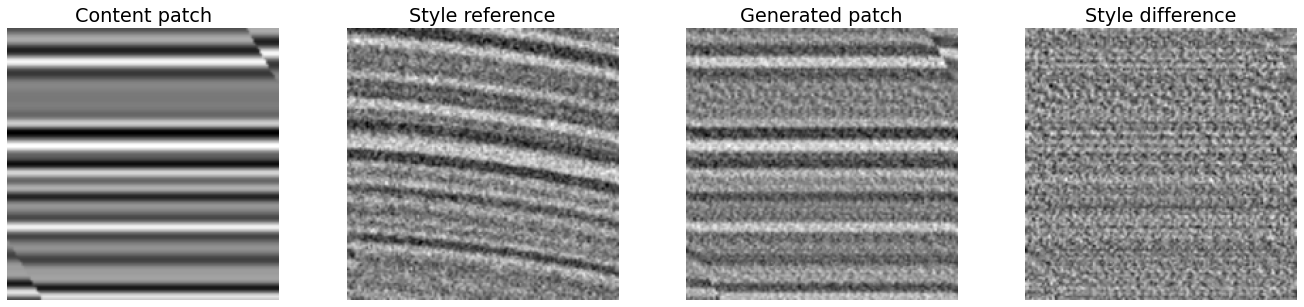

In [11]:
content_gaussian, style_gaussian, output_gaussian = do_style_transfer('synthetic_ours', 'synthetic_ours_gaussian', '1000000', '192', '192', 2000, correction = 130)

content 122.80455186631944 52.90693520985326
style 130.624267578125 30.325200808845516
output 130.14425998263889 31.197564004602956
KstestResult(statistic=0.004752998336880032, pvalue=0.37443960895461514)


(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   2.,   0.,
          0.,   0.,   0.,   5.,   2.,   3.,   5.,   4.,   5.,   4.,   7.,
          7.,   7.,   2.,  10.,   4.,  13.,   6.,   8.,  11.,  12.,  12.,
         14.,  25.,  10.,  22.,  15.,  21.,  24.,  34.,  31.,  49.,  29.,
         53.,  27.,  59.,  58.,  56.,  54.,  51.,  68.,  64.,  79.,  68.,
        106.,  82., 110., 101., 130., 103., 174., 116., 147., 154., 154.,
        198., 157., 210., 187., 231., 183., 211., 220., 275., 211., 288.,
        270., 310., 276., 339., 307., 315., 379., 344., 411., 361., 370.,
        366., 453., 394., 442., 461., 486., 386., 507., 420., 459., 469.,
        505., 475., 502., 536., 490., 539., 493., 542., 466., 529., 535.,
        478., 493., 529., 481., 543., 481., 466., 519., 478., 485., 458.,
        519., 424., 436., 405., 440., 

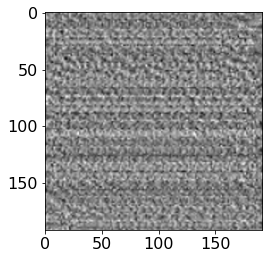

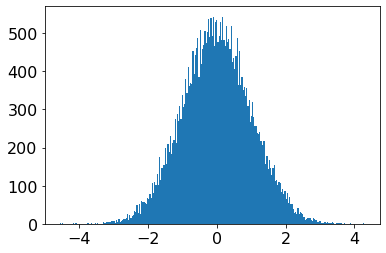

In [12]:
from scipy import stats
target0 = output_gaussian - normalize(content_gaussian, 127.5-130/2, 127.5+130/2)
target1 = output_gaussian - normalize(style_gaussian, 127.5-130/2, 127.5+130/2)
plt.figure()
plt.imshow(target0, cmap = 'gray')
print('content', content_gaussian.mean(), content_gaussian.std())
print('style', style_gaussian.mean(), style_gaussian.std())
print('output', output_gaussian.mean(), output_gaussian.std())
u = target0.mean()
std = target0.std() 
print(stats.kstest(target0.flatten(), 'norm', (u, std)))
plt.figure()
plt.hist((target0.flatten() - u)/std, bins=255)
# plt.bar(target.flatten(), 20, linewidth=10)
# print(target.shape)
# ks2d2s(target.flatten(),np.random.normal(loc=0,scale=10*10, size=(192,192)))
# print(shapiro(target))

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


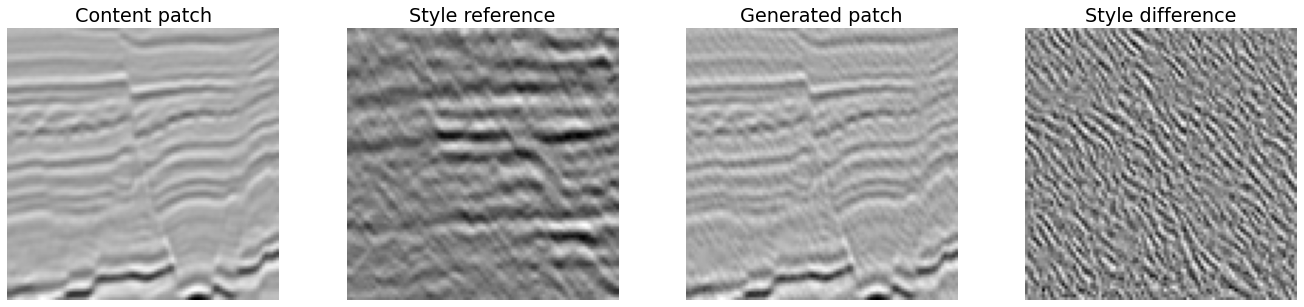

In [13]:
content_thebe, style_thebe, output_thebe = do_style_transfer('thebe_fault', 'beatrice', '10000000', '96', '256', 200, seed = 0)

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


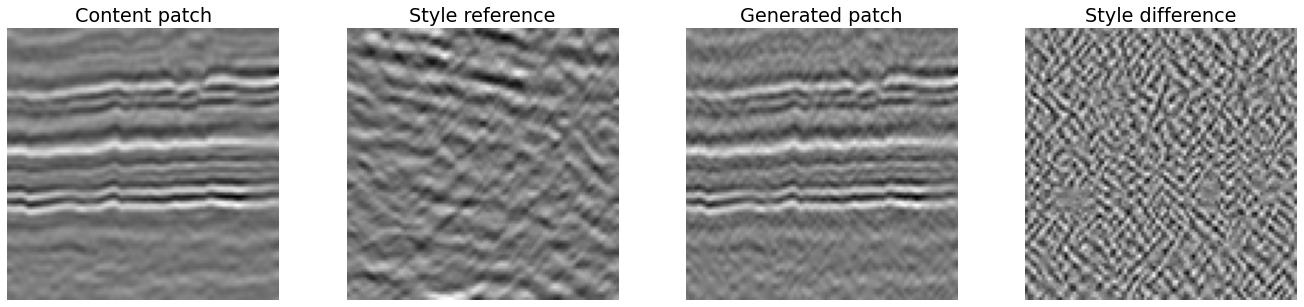

In [15]:
content_thebe_1, style_thebe_1, output_thebe_1 = do_style_transfer('thebe_fault', 'beatrice', '10000000', '96', '256', 200, seed = 1)

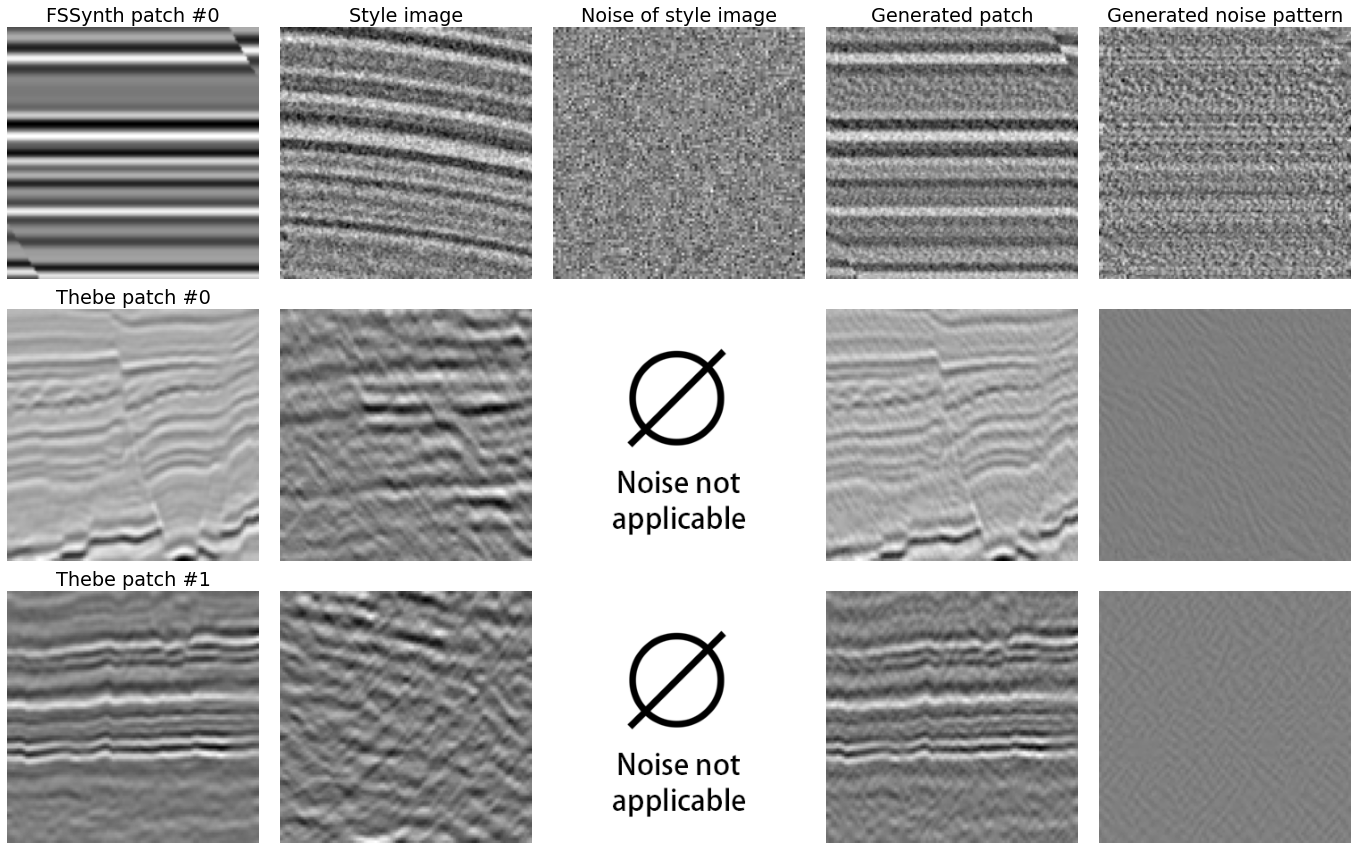

In [16]:
f, axarr = plt.subplots(3, 5, figsize = (25,15))
[axi.set_axis_off() for axi in axarr.ravel()]
plt.subplots_adjust(wspace =-0.1, hspace =0.12)
plt.rcParams.update({'font.size': 16})

axarr[0, 0].set_title('FSSynth patch #0')
axarr[0, 0].imshow(content_gaussian, cmap='gray')
axarr[0, 1].set_title('Style image')
axarr[0, 1].imshow(style_gaussian, cmap='gray')
axarr[0, 2].set_title('Noise of style image')
axarr[0, 2].imshow(np.random.normal(loc=0,scale=10*10, size=(96,96)), cmap='gray')
axarr[0, 3].set_title('Generated patch')
axarr[0, 3].imshow(output_gaussian, cmap='gray')
axarr[0, 4].set_title('Generated noise pattern')
axarr[0, 4].imshow(output_gaussian - normalize(content_gaussian, 128-130/2, 128+130/2), cmap='gray')

axarr[1, 0].set_title('Thebe patch #0')
axarr[1, 0].imshow(content_thebe, cmap='gray')
# axarr[1, 1].set_title('Style reference #0')
axarr[1, 1].imshow(style_thebe, cmap='gray')
# axarr[1, 2].set_title('Noise of style reference')
axarr[1, 2].imshow(Image.open('no_noise.png'), cmap='seismic')
# axarr[1, 3].set_title('Generated Thebe patch #0')
axarr[1, 3].imshow(output_thebe, cmap='gray')
# axarr[1, 4].set_title('Generated Thebe noise #0')
axarr[1, 4].imshow(output_thebe - content_thebe, cmap='gray', vmin=-128, vmax=128)

axarr[2, 0].set_title('Thebe patch #1')
axarr[2, 0].imshow(content_thebe_1, cmap='gray')
# axarr[2, 1].set_title('Style reference #1')
axarr[2, 1].imshow(style_thebe_1, cmap='gray')
# axarr[2, 2].set_title('Noise of style reference')
axarr[2, 2].imshow(Image.open('no_noise.png'), cmap='seismic')
# axarr[2, 3].set_title('Generated Thebe patch #1')
axarr[2, 3].imshow(output_thebe_1, cmap='gray')
# axarr[2, 4].set_title('Generated Thebe noise #1')
axarr[2, 4].imshow(output_thebe_1 - content_thebe_1, cmap='gray', vmin=-128, vmax=128)

plt.savefig('NST_samples.pdf', bbox_inches='tight')

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


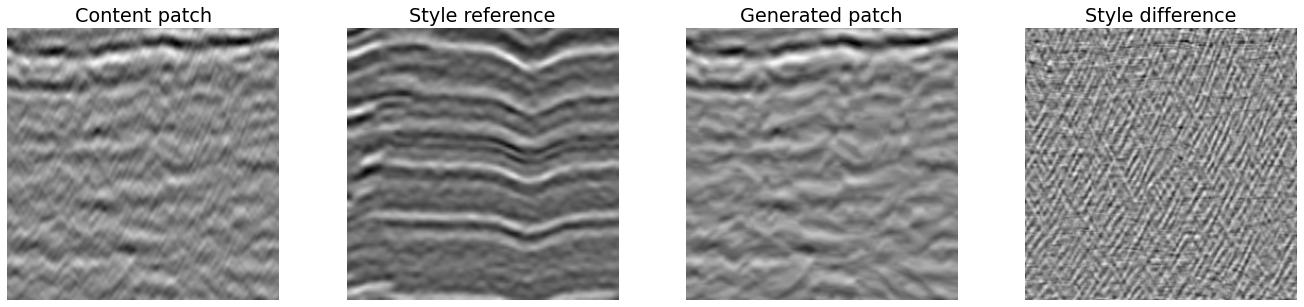

In [17]:
# beatrice --> faultseg works well
content_beatrice, style_beatrice, output_beatrice = do_style_transfer('beatrice', 'faultseg', '10000000', '256', '96', 200, seed = 0)

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


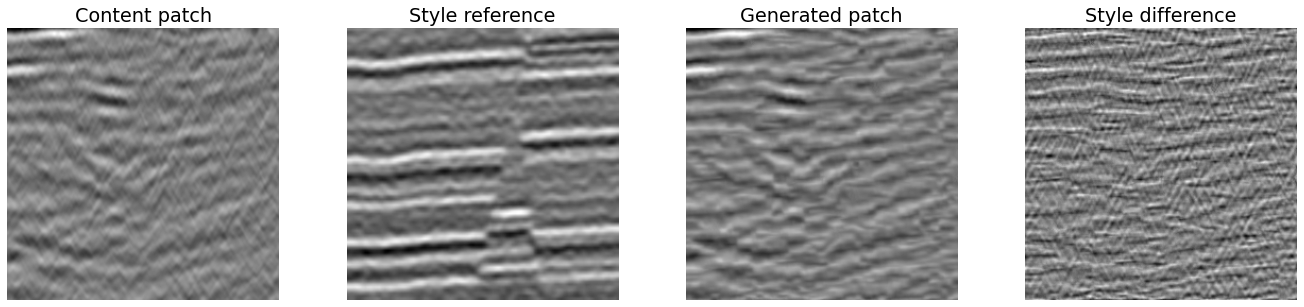

In [18]:
# beatrice --> faultseg badly works
content_beatrice, style_beatrice, output_beatrice = do_style_transfer('beatrice', 'faultseg', '10000000', '256', '96', 200, seed = 5)

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


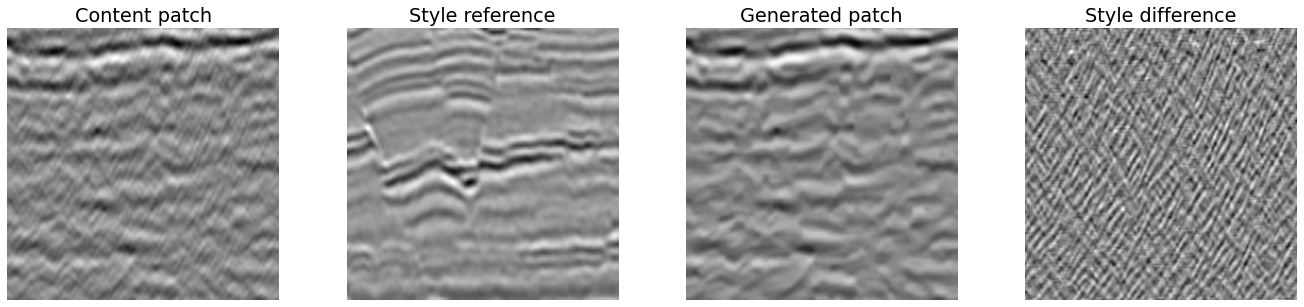

In [19]:
# beatrice --> thebe_fault works well
content_beatrice, style_beatrice, output_beatrice = do_style_transfer('beatrice', 'thebe_fault', '10000000', '256', '96', 200, seed = 0)

/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/haiwen/anaconda3/envs/dncnn/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


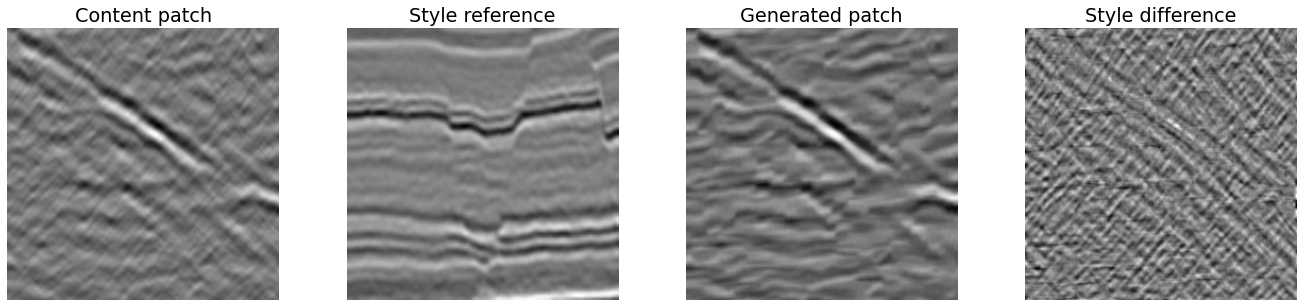

In [20]:
# beatrice --> thebe_fault badly works
content_beatrice, style_beatrice, output_beatrice = do_style_transfer('beatrice', 'thebe_fault', '10000000', '256', '96', 200, seed = 20)